In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm.auto import tqdm

In [2]:
def get_ztest(group1, group2, print_result=True):
    # Количество успехов в каждой выборке
    count = np.array([
        np.count_nonzero(group1),
        np.count_nonzero(group2)
    ])
    
    # Общее количество испытаний в каждой выборке
    nobs = np.array([
        np.size(group1),
        np.size(group2)
    ])
    
    # Выполняем Z-тест для двух пропорций
    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    if print_result:
        if p_value < 0.05: print('H0 rejected. p-value={}'.format(p_value))
        else: print('Сan\'t reject H0. p-value={}'.format(p_value))
    else:
        return p_value


def get_chi2test(group1, group2, print_result=True):
    # Таблица сопряженности количества успехов и неудач в каждой выборке
    contingency_table = np.array([
        [np.count_nonzero(group1), np.size(group1)], 
        [np.count_nonzero(group2), np.size(group1)]
    ])
    
    # Выполнение теста Хи-квадрат Пирсона
    chi2, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)

    if print_result:
        if p_value < 0.05: print('H0 rejected. p-value={}'.format(p_value))
        else: print('Сan\'t reject H0. p-value={}'.format(p_value))
    else:
        return p_value


def ttest_welch(group1, group2, print_result=True):
    # Выполнение t-теста Уэлча
    p_value = stats.ttest_ind(group1, group2, equal_var=False).pvalue

    if print_result:
        if p_value < 0.05: print('H0 rejected. p-value={}'.format(p_value))
        else: print('Сan\'t reject H0. p-value={}'.format(p_value))
    else:
        return p_value


def ttest_student(group1, group2, print_result=False):
    # Выполнение t-теста Стьюдента
    p_value = stats.ttest_ind(group1, group2, equal_var=True).pvalue

    if print_result:
        if p_value < 0.05: print('H0 rejected. p-value={}'.format(p_value))
        else: print('Сan\'t reject H0. p-value={}'.format(p_value))
    else:
        return p_value


def aatest_sim(
    data, 
    stattest, 
    sample_size=0.9, 
    simulations=1000, 
    replace=False, 
    visualization=True,
    pvalue=0.05
):

    boot_len = int( sample_size*np.size(data) )
    group1, group2, result = None, None, []
    
    for _ in tqdm(range(simulations)):
        
        group1 = data.sample(
            boot_len,
            replace=False # выбранные значени доступны для повторного взятия
        )#.values
        group2 = data.sample(
            boot_len,
            replace=False
        )#.values
    
        result.append( stattest(group1, group2, print_result=False) )

    if visualization:
        sns.histplot(result)
    
    # считаем длину отфильтрованного списка со значениями p values <= 0.05
    falsepositive = len(list(filter(lambda i: i <= pvalue, result)))
    FPR = round(falsepositive / boot_len, 4)
    print("FPR={}, те {}% p-values оказались меньше либо равны {}".format(FPR, FPR*100, pvalue))


# Функция взята из karpov.courses
def get_bootstrap(
    group1, # числовые значения первой выборки
    group2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(group1), len(group2)])
    boot_data = []

    for i in tqdm(range(boot_it)):
        samples_1 = group1.sample(
            boot_len,
            replace=True # выбранные значения доступны для повторного взятия
        ).values

        samples_2 = group2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1-samples_2))

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = stats.norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {
        "boot_data": boot_data,
        "quants": quants,
        "p_value": p_value
    }

# Импорт и очистка данных

In [3]:
file = '/kaggle/input/ab-test-data/AB_Test_Results.csv'
data = pd.read_csv(file)

data.head(5)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
display(
    data.VARIANT_NAME.unique(), 
    data.nunique()
)

array(['variant', 'control'], dtype=object)

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

В столбца USER_ID, из 10000 строк, уникальных значений - 6324.

По задаче, предполагаю, что данные должны быть отражены суммарно по пользователю и группе, те дублей в USER_ID быть не должно.

Дальнейшии действия:
1. Удаляем пользователей, которые попали в обе группы
2. Удаляем полные дубли (по совпадению всех значений столбцов USER_ID, VARIANT_NAME, REVENUE), оставляем одно значение
3. Если что-то останется, то смотрим дальше

In [6]:
# выявление кол-ва уник групп у пользователя
# если >1, то True, иначе - False

users_get_few_group = data.groupby(by='USER_ID')['VARIANT_NAME'].agg({'nunique'}).reset_index()
users_get_few_group = { i: True for i in users_get_few_group[users_get_few_group['nunique'] > 1]['USER_ID'].values }

data['multi_group'] = data['USER_ID'].apply( lambda x: users_get_few_group.get(x, False) )

# оставляем данные со значением multi_group == False, 
#     те пользователей, которые попали только в одну группу
data_cleared = data[data['multi_group'] == False].copy()
data_cleared.drop(columns='multi_group', inplace=True)

del users_get_few_group

In [7]:
# удаляем полные дубли
data_cleared = data_cleared.drop_duplicates(
    subset=['USER_ID', 'VARIANT_NAME', 'REVENUE'], keep='first', inplace=False, ignore_index=True)

In [8]:
# смотрим что осталось
display(
    data_cleared.info(),
    data_cleared.nunique()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4821 entries, 0 to 4820
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       4821 non-null   int64  
 1   VARIANT_NAME  4821 non-null   object 
 2   REVENUE       4821 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 113.1+ KB


None

USER_ID         4783
VARIANT_NAME       2
REVENUE           70
dtype: int64

Все еще есть дубликаты USER_ID. Тк, пользователей с 2 группами и полные совпадения по столбцам мы убрали, возможно, остались дубли с разными значениями в REVENUE.



In [9]:
# проверим предположение, описанное выше
data_cleared[data_cleared.duplicated(
    subset=['USER_ID', 'VARIANT_NAME'], keep=False) == True].sort_values(by='USER_ID')

,USER_ID,VARIANT_NAME,REVENUE
3359,124,control,1.25
4070,124,control,0.00
2440,169,control,4.33
3315,169,control,0.00
2723,282,control,0.00
...,...,...,...
10,8927,variant,0.00
1063,9766,control,0.00
3317,9766,control,3.79
1257,9928,variant,0.00


Просуммируем данные по USER_ID, VARIANT_NAME

In [10]:
# суммируем по USER_ID, VARIANT_NAME
data_cleared = data_cleared.groupby(by=['USER_ID', 'VARIANT_NAME']).REVENUE.sum().reset_index()

In [11]:
display(
    data_cleared.info(),
    data_cleared.nunique()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783 entries, 0 to 4782
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       4783 non-null   int64  
 1   VARIANT_NAME  4783 non-null   object 
 2   REVENUE       4783 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 112.2+ KB


None

USER_ID         4783
VARIANT_NAME       2
REVENUE           71
dtype: int64

Остались только уникальные USER_ID

In [12]:
# для оценки конверсии, добавим флаг факта покупки
# если REVENUE = 0, то False. если REVENUE > 0, то True.

data_cleared['IS_PAYED'] = data_cleared['REVENUE'].apply(lambda x: True if x > 0 else False)

In [13]:
# показатели на основе всех данных
data_cleared.groupby(by=['VARIANT_NAME']).REVENUE.describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,2390.0,0.196887,4.172201,0.0,0.0,0.0,0.0,196.01
variant,2393.0,0.074935,0.858207,0.0,0.0,0.0,0.0,23.04


In [14]:
# показатели в разрезе значения IS_PAYED
data_cleared.groupby(by=['VARIANT_NAME', 'IS_PAYED']).REVENUE.describe()

count      mean        std   min     25%   50%  \
VARIANT_NAME IS_PAYED                                                    
control      False     2336.0  0.000000   0.000000  0.00  0.0000  0.00   
             True        54.0  8.714074  26.627446  0.02  1.5850  3.12   
variant      False     2351.0  0.000000   0.000000  0.00  0.0000  0.00   
             True        42.0  4.269524   4.962253  0.02  1.2625  2.97   

                          75%     max  
VARIANT_NAME IS_PAYED                  
control      False     0.0000    0.00  
             True      6.0075  196.01  
variant      False     0.0000    0.00  
             True      4.2700   23.04

<Axes: xlabel='REVENUE', ylabel='Count'>

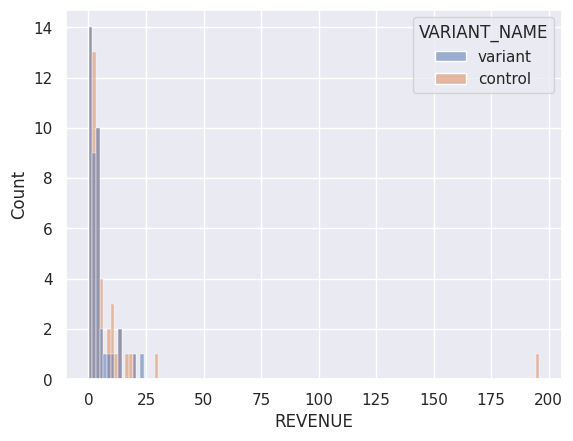

In [15]:
sns.histplot(data=data_cleared[(data_cleared['IS_PAYED'] == True)], x='REVENUE', hue='VARIANT_NAME')

Видим, чтто группа "control" имеет явный выброс. При этом, большенство значений находится в пределах 25. Исключим все, что больше 25. Будет -2 значения в группы "control"

In [16]:
data_cleared = data_cleared[data_cleared.REVENUE < 25]

# Обработанные данные

In [17]:
# показатели на основе всех данных
data_cleared.groupby(by=['VARIANT_NAME']).REVENUE.describe()

,count,mean,std,min,25%,50%,75%,max
VARIANT_NAME,,,,,,,,
control,2388.0,0.102693,0.997238,0.0,0.0,0.0,0.0,20.07
variant,2393.0,0.074935,0.858207,0.0,0.0,0.0,0.0,23.04


In [18]:
# показатели в разрезе значения IS_PAYED
data_cleared.groupby(by=['VARIANT_NAME', 'IS_PAYED']).REVENUE.describe()

count      mean       std   min     25%   50%     75%  \
VARIANT_NAME IS_PAYED                                                           
control      False     2336.0  0.000000  0.000000  0.00  0.0000  0.00  0.0000   
             True        52.0  4.715962  4.935908  0.02  1.4825  2.99  4.9575   
variant      False     2351.0  0.000000  0.000000  0.00  0.0000  0.00  0.0000   
             True        42.0  4.269524  4.962253  0.02  1.2625  2.97  4.2700   

                         max  
VARIANT_NAME IS_PAYED         
control      False      0.00  
             True      20.07  
variant      False      0.00  
             True      23.04

<Axes: xlabel='REVENUE', ylabel='Count'>

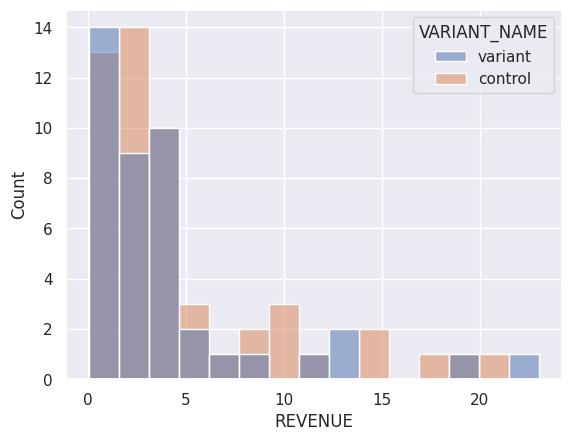

In [19]:
sns.histplot(data=data_cleared[(data_cleared['IS_PAYED'] == True)], x='REVENUE', hue='VARIANT_NAME')

# Статанализ

Изначальный датасет **data** => в "чистый" датасет **data_cleared**

Метрики для оценки:
1. Конверсия в покупку (конверсия)
2. ARPU (пользовательская)

Параметры для теста:
* H0 - нет разницы между группами
* H1 - есть разница между группами
* alpha = 0.05

## 1. Конверсия

Распределение данных отлично от нормального, поэтому предпочтительны непараметрические тесты: Манн-Уитни, хи-квадрат (критерий согласия Пирсона)/критерий Фишера, непараметрический бутстреп. НО:
* тест Манн-Уитни не подходит, тк в данных много повторяющихся значений - тест становится менее чувствительным.
* критерий Фишера предпочтителен для небольшого объема данны

Для оценки конверсии, рассмотрим тесты: Z-тест, хи-квадрат, непараметрический бутстреп.

## A/A-тест и FPR-метрика

False Positive Rate (FPR) = FP / (FP + TN) = FP/N(sim), где FP - количество False Positive, TN - количество True Negative. Ложно положительный результат - результат определяется как положительный при том, что он на самом деле отрицательный.

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR=0.0, те 0.0% p-values оказались меньше либо равны 0.05


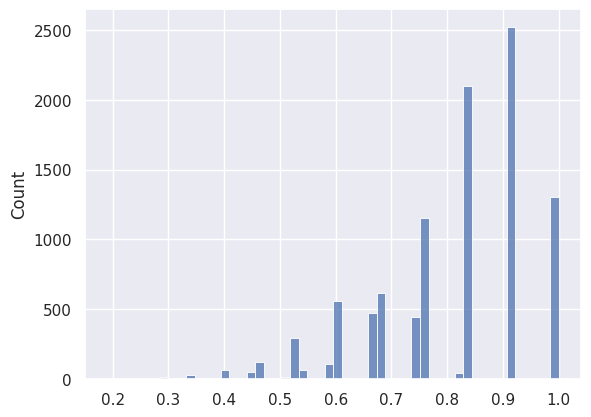

In [20]:
aatest_sim(
    data_cleared[data_cleared.VARIANT_NAME == 'control'].IS_PAYED,
    stattest=get_ztest,
    sample_size=0.9,
    simulations=10000,
    replace=False, 
    visualization=True,
    pvalue=0.05
)

### ztest и chi2

In [21]:
group1 = data_cleared[data_cleared.VARIANT_NAME == 'control'].IS_PAYED
group2 = data_cleared[data_cleared.VARIANT_NAME == 'variant'].IS_PAYED

get_ztest( group1, group2 )
get_chi2test( group1, group2 )

del group1, group2

Сan't reject H0. p-value=0.29282068359112357
Сan't reject H0. p-value=0.359002052778134


### bootstrap

  0%|          | 0/10000 [00:00<?, ?it/s]

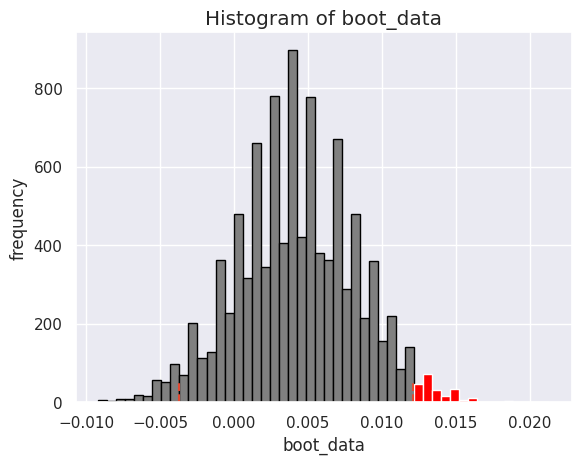

p_value: 0.29345495477466466
quants:
0.025   -0.003761
0.975    0.012119
Name: 0, dtype: float64
Сan't reject H0


In [22]:
bootstrap_result = get_bootstrap(
    data_cleared[data_cleared.VARIANT_NAME == 'control'].IS_PAYED.apply(lambda x: 1 if x == True else 0),
    data_cleared[data_cleared.VARIANT_NAME == 'variant'].IS_PAYED.apply(lambda x: 1 if x == True else 0),
    10000
)

print('p_value: {}\nquants:\n{}'.format(bootstrap_result['p_value'], bootstrap_result['quants'][0]))

if bootstrap_result['p_value'] < 0.05: print('H0 rejected')
else: print('Сan\'t reject H0')

## 2. ARPU

In [23]:
# H0: Дисперсии во всех группах равны (гомогенны)
# H1: Дисперсии в каких-то группах отличаются (гетерогенны)

stats.levene(    
    data_cleared[data_cleared.VARIANT_NAME == 'control'].REVENUE,
    data_cleared[data_cleared.VARIANT_NAME == 'variant'].REVENUE, 
    center='mean'
)

LeveneResult(statistic=4.143071854978669, pvalue=0.04186029862965452)

### A/A-тест и FPR-метрика

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR=0.0, те 0.0% p-values оказались меньше либо равны 0.05


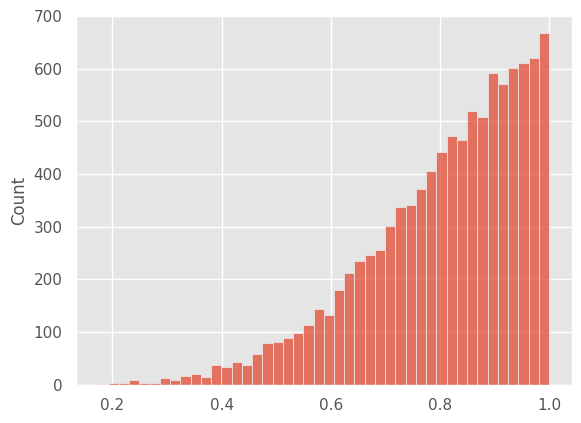

In [24]:
aatest_sim(
    data_cleared[data_cleared.VARIANT_NAME == 'control'].REVENUE,
    stattest=ttest_welch,
    sample_size=0.9,
    simulations=10000,
    replace=False, 
    visualization=True,
    pvalue=0.05
)

### bootstrap

  0%|          | 0/10000 [00:00<?, ?it/s]

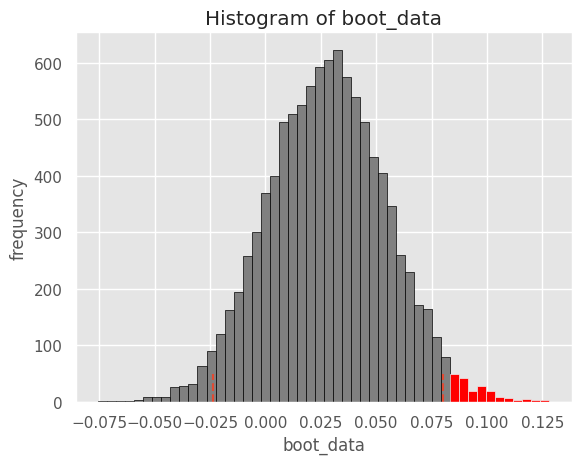

p_value: 0.29790659897449767
quants:
0.025   -0.023624
0.975    0.080089
Name: 0, dtype: float64
Сan't reject H0


In [25]:
bootstrap_result = get_bootstrap(
    data_cleared[data_cleared.VARIANT_NAME == 'control'].REVENUE,
    data_cleared[data_cleared.VARIANT_NAME == 'variant'].REVENUE,
    10000
)

print('p_value: {}\nquants:\n{}'.format(bootstrap_result['p_value'], bootstrap_result['quants'][0]))

if bootstrap_result['p_value'] < 0.05: print('H0 rejected')
else: print('Сan\'t reject H0')

### t-test

In [26]:
group1 = data_cleared[data_cleared.VARIANT_NAME == 'control'].REVENUE
group2 = data_cleared[data_cleared.VARIANT_NAME == 'variant'].REVENUE

ttest_student( group1, group2, True )
ttest_welch( group1, group2, True )

del group1, group2

Сan't reject H0. p-value=0.302315752284478
Сan't reject H0. p-value=0.30239230098896447


# Вывод

На основе проведенных тестов, мы не можем отвергнуть H0 ни в отношении конверсии в покупку, ни в отношении arpu.